# Temperature-Salinity diagram

This notebook shows how to plot a temperature-salinity diagram which is weighted by volume using xhistogram. 

The notebook is written using output from MOM6. If you want to use output from MOM5 the relevant diagnostics are as follows;
- Temperature: `thetao`
- Salinity:  `so`
  
Tthere is a cell volume variable (`volcello`).

**Requirements**: The conda/analysis3 (or later) module on ARE. A session with 4 cores is sufficient for this example but more cores will be needed for larger datasets. 
Based on: https://cosima-recipes.readthedocs.io/en/latest/03-Mains/Temperature_Salinity_Diagram.html

Firstly, we load all required modules and start a client.

In [6]:
# analysis libraries
import xarray as xr
import numpy as np
import gsw
from xhistogram.xarray import histogram as xhistogram

from dask.distributed import Client

# plotting libaries
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as colors

In [1]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40215,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39595,Total threads: 1
Dashboard: /proxy/38297/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35539,


## Load data

In [14]:
from esmvalcore.dataset import Dataset

thetao_OM2 = Dataset(short_name='thetao', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="0365/0366",
    dataset="ACCESS-OM2", grid="gn")

so_OM2 = thetao_OM2.copy(short_name='so')

# volume - supplementary ? Ofx
thetao_OM2.add_supplementary(mip='Ofx', short_name='volcello')
thetao_OM2.load().summary(shorten=True)


'sea_water_potential_temperature / (degC) (time: 24; depth: 50; cell index along second dimension: 300; cell index along first dimension: 360)'

### Subset the data regionally

Select the region and coordinates of meridional section for the temperature-salinity diagram.

In [15]:
from esmvalcore.preprocessor import extract_region, extract_transect, convert_units
from esmvalcore.preprocessor import axis_statistics, regrid, histogram

cube = regrid(thetao_OM2.load(), '0.5x0.5', scheme='linear')
cube.units = 'K' # thetao_OM2.load().units #incorrectly recorded as degC
cube = convert_units(cube, 'degC')
# not for irregular arrays # extract transect 0-360 values for longitude, -25(west) is 335
thetao = extract_transect(cube, longitude=335.0, latitude=[-90.0, -37.0]) 

cube = regrid(so_OM2.load(), '0.5x0.5', scheme='linear')
so = extract_transect(cube, longitude=335.0, latitude=[-90.0, -37.0]) # not for irregular arrays

# need volume for weights later
vol_cube = regrid(thetao_OM2.supplementaries[0].load(), '0.5x0.5', scheme='linear')
cell_vol = extract_transect(vol_cube, longitude=335.0, latitude=[-90.0, -37.0])

In [4]:
# check datasets
# so_OM2.load()
thetao.data.max()
# thetao_OM2.load().units #incorrect as degC

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.67 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


20.23205

And we subset the previously loaded data using this function. 

### Convert Temperature and Salinity units

Now we need to convert from potential temperature to conservative temperature and from practical salinity to absolute salinity. If adapting this to MOM5 output, make sure you check the temperature and salinity definitions/units - they may be different than for MOM6! To learn more about the different types of salinity and temperature measurements, and how to convert between them, visit the `GSW` toolbox: https://teos-10.github.io/GSW-Python/intro.html

In [7]:
# https://teos-10.github.io/GSW-Python/conversions.html # input xarray
#gsw.conversions.p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)
#gsw.conversions.SA_from_SP(SP, p, lon, lat) #absolute salininity
#gsw.conversions.CT_from_pt(SA, pt)

salt = xr.DataArray.from_iris(so)
temperature = xr.DataArray.from_iris(thetao)

# Calculate ocean pressure (gsw assumes ocean depth is positive upwards, 
# hence the negative applied here)
pressure = gsw.p_from_z(-salt.lev, salt.lat)

# This converts pratical salinity (psu) to absolute salinity (g/kg)
SA = gsw.SA_from_SP(salt, pressure, salt.lon, salt.lat)
SA.attrs = {'units': 'Absolute Salinity (g/kg)'}

# This converts potential temperature (deg C) to conservative temperature (deg C)
CT = gsw.CT_from_pt(salt, temperature)
CT = CT.rename('thetao')
CT.attrs = {'units': 'Conservative temperature (°C)'}

/jobfs/155717886.gadi-pbs/ipykernel_3423408/1263927766.py:6: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  salt = xr.DataArray.from_iris(so)
/jobfs/155717886.gadi-pbs/ipykernel_3423408/1263927766.py:6: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  salt = xr.DataArray.from_iris(so)
/jobfs/155717886.gadi-pbs/ipykernel_3423408/1263927766.py:7: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  temperature = xr.DataArray.from_iris(thetao)
/j

In [9]:
CT = CT.compute()
SA = SA.compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 11.15 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Now load the converted data into memory. Note: You don't need to load the data into memory to run the rest of the script but it can make subsequent calculations faster. However, if you choose to load more data (e.g. a larger region or longer timeframe) then this step might cause the kernel to die. 

### Compute T-S histogram

Now define the function that computes the temperature and salinity bins for the T-S histogram. 

In [8]:
def compute_TS_bins(salt, temperature, volume):
    
    temp_bins = np.arange(np.floor(temperature.min().values)-0.5, np.ceil(temperature.max().values)+0.6, 0.5)
    salt_bins = np.arange(np.floor(salt.min().values)-0.1, np.ceil(salt.max().values)+0.11, 0.1)
    
    # To create density contours in the T-S diagram
    temp_bins_mesh, salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
    TS_density = gsw.density.sigma2(salt_bins_mesh, temp_bins_mesh)
    
    # Create the 2D histogram array containing the temperature and salinity values, 
    # weighted by grid cell volume
    TS_histogram = xhistogram(temperature, salt, bins=(temp_bins, salt_bins), weights=volume)
    TS_histogram = TS_histogram.where(TS_histogram != 0).compute()
    
    return TS_histogram, TS_density, salt_bins_mesh, temp_bins_mesh 

Calculate the histogram. 

In [10]:
%%time

cell_volume = xr.DataArray.from_iris(cell_vol) # to xr
TS_histogram, TS_density, salt_bins_mesh, temp_bins_mesh = compute_TS_bins(SA, CT, cell_volume)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 12.59 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 112 ms, sys: 46.3 ms, total: 158 ms
Wall time: 938 ms


### Plot the histogram

Now we can plot this T-S histogram!

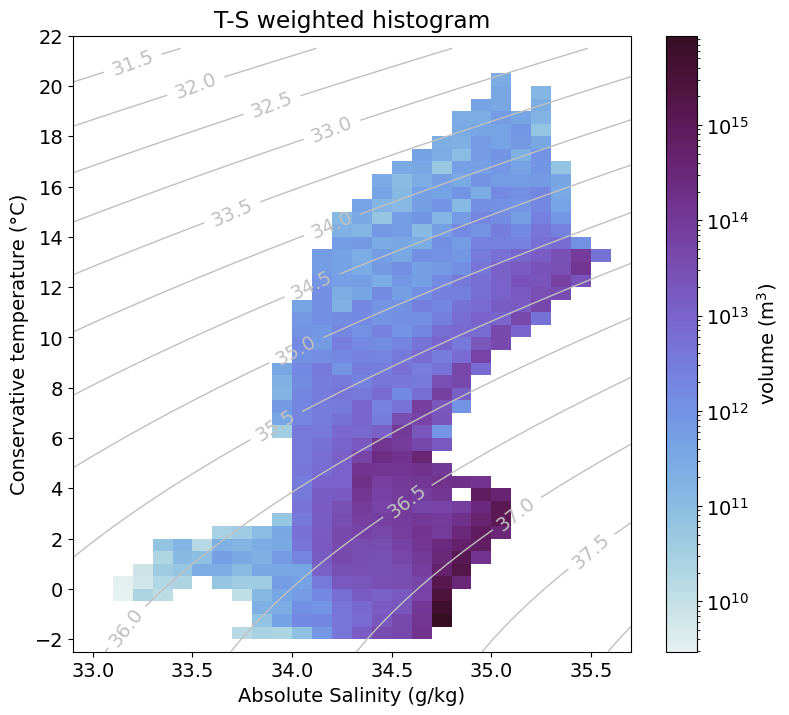

In [13]:
plt.rcParams['font.size']=14
plt.figure(figsize=(9, 8))

# normalize the colorbar to the min and maximum values of the histogram 
# using a LogNormal scale
norm=colors.LogNorm(vmin=TS_histogram.min().values, vmax=TS_histogram.max().values)

# Plot (shade) the TS histogram data
TS_histogram.plot(cmap=cmo.dense, norm=norm, cbar_kwargs=dict(label='volume (m$^{3}$)'))

# Add the density contours
cs = plt.contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)

plt.xlabel(SA.units)
plt.ylabel(CT.units)
plt.title("T-S weighted histogram");

plt.xlim([32.9, 35.7])
plt.yticks(np.arange(-2, 23, 2))

plt.show()

In [12]:
client.close()